In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
import os

## Prepare data

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'concrete_data.csv'))

In [3]:
data.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,ccs
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [24]:
X = data.drop('ccs', axis=1)
y = data['ccs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=1)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(825, 8) (102, 8) (103, 8)
(825,) (102,) (103,)


In [25]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = y_scaler.transform(y_val.values.reshape(-1, 1))

/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/home/simon/miniconda3/envs/diss/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [26]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()

In [27]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true')
    ax.plot(np.arange(0, 90, 0.1), np.arange(0, 90, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [28]:
def msse(pred, y):
    return (np.sum((y - pred)**2)) / y.shape[0]

## Training

In [46]:
model = keras.Sequential([
    keras.layers.Dense(8, input_shape=(8,)),
    #keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(1)
])
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [48]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

In [49]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=[X_val, y_val], callbacks=[early_stop])

Train on 825 samples, validate on 102 samples
Epoch 1/1000
825/825 [==============================] - 1s 786us/step - loss: 1.5006 - mean_absolute_error: 1.0112 - val_loss: 1.1426 - val_mean_absolute_error: 0.8716
Epoch 2/1000
825/825 [==============================] - 0s 197us/step - loss: 1.2599 - mean_absolute_error: 0.9201 - val_loss: 0.9756 - val_mean_absolute_error: 0.7953
Epoch 3/1000
825/825 [==============================] - 0s 317us/step - loss: 1.0786 - mean_absolute_error: 0.8463 - val_loss: 0.8517 - val_mean_absolute_error: 0.7357
Epoch 4/1000
825/825 [==============================] - 0s 286us/step - loss: 0.9376 - mean_absolute_error: 0.7861 - val_loss: 0.7549 - val_mean_absolute_error: 0.6965
Epoch 5/1000
825/825 [==============================] - 0s 268us/step - loss: 0.8300 - mean_absolute_error: 0.7351 - val_loss: 0.6746 - val_mean_absolute_error: 0.6633
Epoch 6/1000
825/825 [==============================] - 0s 234us/step - loss: 0.7437 - mean_absolute_error: 0.6926

Epoch 49/1000
825/825 [==============================] - 0s 246us/step - loss: 0.1961 - mean_absolute_error: 0.3386 - val_loss: 0.2334 - val_mean_absolute_error: 0.3744
Epoch 50/1000
825/825 [==============================] - 0s 238us/step - loss: 0.1937 - mean_absolute_error: 0.3364 - val_loss: 0.2321 - val_mean_absolute_error: 0.3730
Epoch 51/1000
825/825 [==============================] - 0s 257us/step - loss: 0.1915 - mean_absolute_error: 0.3343 - val_loss: 0.2290 - val_mean_absolute_error: 0.3708
Epoch 52/1000
825/825 [==============================] - 0s 253us/step - loss: 0.1892 - mean_absolute_error: 0.3324 - val_loss: 0.2272 - val_mean_absolute_error: 0.3690
Epoch 53/1000
825/825 [==============================] - 0s 235us/step - loss: 0.1865 - mean_absolute_error: 0.3300 - val_loss: 0.2282 - val_mean_absolute_error: 0.3693
Epoch 54/1000
825/825 [==============================] - 0s 267us/step - loss: 0.1849 - mean_absolute_error: 0.3287 - val_loss: 0.2253 - val_mean_absolute_

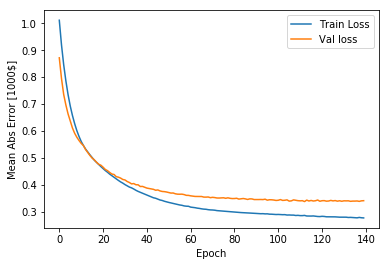

In [50]:
plot_history(history)

In [51]:
pred = y_scaler.inverse_transform(model.predict(X_test).flatten())
msse(pred, y_test)

53.45142429107456

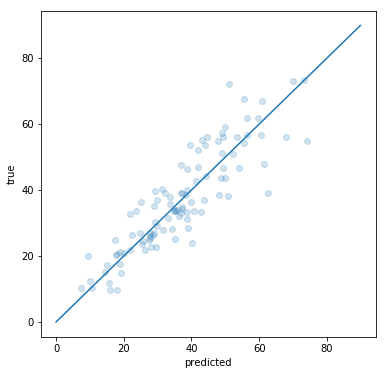

In [52]:
plot_predictions(pred, y_test)

In [53]:
weights = model.get_weights()
np.save('relu_weights', weights, allow_pickle=True)